In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.9 MB/s eta 0:00:00


##Lematización:

- La lematización es el proceso de reducir una palabra a su forma base o raíz, conocida como lema. Por ejemplo, las palabras "corriendo", "corre" y "correrá" tienen el mismo lema "correr".
- El objetivo de la lematización es normalizar las palabras para que las variantes de una misma palabra se consideren iguales en el análisis, lo que ayuda a mejorar la precisión de los modelos de NLP.

##Stopwords:

- Las stopwords son palabras muy comunes en un idioma que a menudo no aportan un significado adicional al texto y se pueden eliminar sin afectar la comprensión del mismo. Ejemplos de stopwords en inglés son "the", "and", "is", etc.
- La eliminación de stopwords es importante para reducir el ruido en los datos y mejorar la eficiencia de los modelos de NLP al centrarse en las palabras más significativas del texto.

In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import re
import string
import contractions
import multiprocessing
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Limpieza del texto

- Normalización de datos

- Eliminación de ruido

- Reducción del vocabulario

- Mejora de la precisión

*clean_text_round1*: Limpia el texto convirtiéndolo a minúsculas, eliminando texto entre corchetes, signos de puntuación y palabras con números.

*clean_text_round2*: Elimina comillas, puntos suspensivos, y saltos de línea del texto.

In [ ]:
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_round2(text):
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text

In [ ]:
lemmatizer = WordNetLemmatizer()
sw = stopwords.words('english')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Inteligencia Artificial/Materia/2024/simpsons_dataset.csv')
print(df.head())

# Asegurarse de que todas las entradas en 'spoken_words' son cadenas de texto
df['spoken_words'] = df['spoken_words'].astype(str)

# Aplicar las funciones de limpieza usando funciones lambda (rounds)
round0 = lambda x: contractions.fix(x)
round1 = lambda x: clean_text_round1(x)
round2 = lambda x: clean_text_round2(x)

# Aplicar cada ronda de limpieza secuencialmente
df['spoken_words'] = df['spoken_words'].apply(round0)
df['spoken_words'] = df['spoken_words'].apply(round1)
df['spoken_words'] = df['spoken_words'].apply(round2)


df.head()

        raw_character_text                                       spoken_words
0              Miss Hoover  No, actually, it was a little of both. Sometim...
1             Lisa Simpson                             Where's Mr. Bergstrom?
2              Miss Hoover  I don't know. Although I'd sure like to talk t...
3             Lisa Simpson                         That life is worth living.
4  Edna Krabappel-Flanders  The polls will be open from now until the end ...


,raw_character_text,spoken_words
0,Miss Hoover,no actually it was a little of both sometim...
1,Lisa Simpson,where is mr bergstrom
2,Miss Hoover,i do not know although i would sure like to t...
3,Lisa Simpson,that life is worth living
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...


In [ ]:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20, window=2, vector_size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores)

###Tokenización de las frases

- Convierte cada frase en una lista de palabras, tokenizando el texto por espacios. input_data se convierte en una lista de listas de palabras.

In [ ]:
input_data = [row.split() for row in df['spoken_words']]
input_data[0]

['no',
 'actually',
 'it',
 'was',
 'a',
 'little',
 'of',
 'both',
 'sometimes',
 'when',
 'a',
 'disease',
 'is',
 'in',
 'all',
 'the',
 'magazines',
 'and',
 'all',
 'the',
 'news',
 'shows',
 'it',
 'is',
 'only',
 'natural',
 'that',
 'you',
 'think',
 'you',
 'have',
 'it']

###Construcción de bigramas

**"El gato está sobre la mesa"**

Los bigramas de esta oración serían:

- "El gato"
- "gato está"
- "está sobre"
- "sobre la"
- "la mesa"

Cada bigrama representa dos palabras consecutivas en la oración original.
  
Captura de Contexto Local




In [ ]:
phrases = Phrases(input_data, min_count=30, progress_per=1000)
bigram = Phraser(phrases)
sentences = bigram[input_data]

<ipython-input-15-af2627a3c7c1>:8: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


###Construcción del vocabulario

In [ ]:
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

In [ ]:
# Obtener las palabras del vocabulario
words = list(w2v_model.wv.key_to_index.keys())
print (len(words))

4318


In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.522838830947876),
 ('dad', 0.458978533744812),
 ('homie', 0.44186633825302124),
 ('mom', 0.3987717032432556),
 ('lisa', 0.39592674374580383),
 ('bart', 0.3880963623523712),
 ('guys', 0.367495596408844),
 ('simpson', 0.3574353754520416),
 ('moe', 0.35006093978881836),
 ('herb', 0.34959566593170166)]

In [ ]:
w2v_model.wv.most_similar(positive=["beer"])

[('duff', 0.6374707221984863),
 ('baron', 0.6204781532287598),
 ('mug', 0.5785999298095703),
 ('chug', 0.5628378987312317),
 ('bottles', 0.5306209325790405),
 ('blimp', 0.5083188414573669),
 ('champagne', 0.5036320090293884),
 ('drank', 0.5024460554122925),
 ('krustyburger', 0.46337801218032837),
 ('drink', 0.4535473883152008)]

In [ ]:
w2v_model.wv.most_similar(positive=["homer", "beer"])

[('duff', 0.4785405397415161),
 ('baron', 0.4765430688858032),
 ('moe', 0.444746732711792),
 ('drinking', 0.4034419357776642),
 ('champagne', 0.3988872766494751),
 ('mug', 0.3927585482597351),
 ('blimp', 0.3927452266216278),
 ('marge', 0.38496214151382446),
 ('lemonade', 0.38152948021888733),
 ('chug', 0.37749189138412476)]

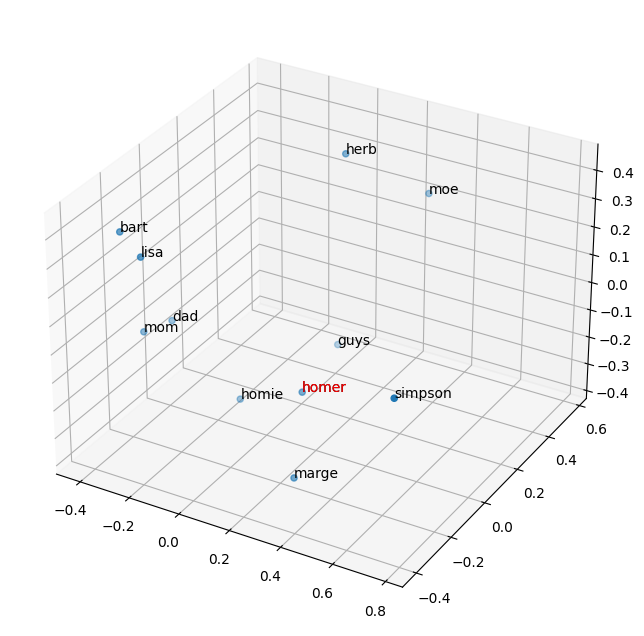

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Seleccionar palabra específica y sus vecinas
target_word = 'homer'  # Reemplaza con la palabra de interés
neighbors = w2v_model.wv.most_similar(target_word, topn=10)  # Obtener las 10 palabras vecinas más similares
words = [target_word] + [neighbor[0] for neighbor in neighbors]
word_vectors = np.array([w2v_model.wv[word] for word in words])

# Reducir dimensiones a 3D
pca = PCA(n_components=3)
word_vectors_pca = pca.fit_transform(word_vectors)

# Crear una figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Dibujar las palabras en el espacio 3D
ax.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], word_vectors_pca[:, 2])

# Etiquetas para las palabras
for i, word in enumerate(words):
    ax.text(word_vectors_pca[i, 0], word_vectors_pca[i, 1], word_vectors_pca[i, 2], word)

# Destacar la palabra objetivo en rojo
ax.text(word_vectors_pca[0, 0], word_vectors_pca[0, 1], word_vectors_pca[0, 2], target_word, color='red', fontsize=10)

# Mostrar la gráfica
plt.show()

In [ ]:
analogous_words = w2v_model.wv.most_similar(positive=['bart', 'marge'], negative=['homer'], topn=1)
print("La palabra que completa la analogía 'homero es a bart como marge es a ...' es:", analogous_words[0][0])

La palabra que completa la analogía 'homero es a bart como marge es a ...' es: lisa
